# 4. Unsupervised Learning: Detecting Kubernetes Anomalies

## Introduction

Welcome to the fourth notebook in our AI for Kubernetes series! In this notebook, we focus on **unsupervised learning** to identify anomalies in Kubernetes metrics. Unlike supervised learning, which requires labeled datasets, unsupervised learning works directly with raw data to uncover hidden patterns and deviations.

### Objectives

By the end of this notebook, you will:
- Understand how clustering can identify patterns and detect anomalies in Kubernetes operational data.
- Apply **K-Means Clustering** to group similar data points and flag outliers.
- Explore clustering results using interactive tools to adjust parameters and thresholds.
- Visualize and interpret cluster assignments and anomalies to gain actionable insights.

### Key Features:

- Introduce clustering as a tool for anomaly detection in unlabeled datasets.
- Apply **K-Means Clustering** to real Kubernetes metrics, such as CPU and memory efficiency.
- Use interactive widgets and visualizations to explore and understand clustering results.
- Detect operational risks and outliers that could indicate potential issues.

### Unsupervised Learning and Clustering

Unsupervised learning is a machine learning approach that identifies patterns and structures in unlabeled data. This is particularly useful in Kubernetes operations, where labeled datasets might not always be available.

#### What is Clustering?

Clustering is one of the most common unsupervised learning techniques. It groups similar data points based on their features, uncovering natural structures in the data. For Kubernetes, clustering can help identify patterns such as:

- Pods with similar resource usage (e.g., CPU, memory, or disk I/O).
- Nodes with comparable performance metrics.
- Unusual behaviors that deviate significantly from expected patterns (anomalies).

By analyzing these clusters, we can detect potential issues, such as:
- Resource constraints (e.g., over-utilized CPU or memory).
- Unexpected spikes in latency or I/O operations.
- Anomalies that may indicate misconfigurations or performance degradation.

#### Why Use Clustering for Anomaly Detection?

In Kubernetes operations, anomalies can highlight critical issues that require attention, such as:

- Pods or nodes underperforming due to resource constraints.
- Unexpected spikes in latency, disk I/O, or network traffic.
- Potential misconfigurations or bottlenecks leading to operational risks.

Clustering groups similar data points together and identifies outliers—data points that deviate significantly from the cluster they belong to. These outliers often represent anomalies and can help you proactively detect and address issues in your system.

## 1. Install Required Libraries

Run the following command to install the necessary libraries:

In [21]:
# Install necessary libraries
%pip install pandas numpy matplotlib seaborn scikit-learn ipywidgets --quiet

Note: you may need to restart the kernel to use updated packages.


## 2. Dataset Preprocessing for K-Means

Before applying K-Means, we need to prepare the dataset to ensure the clustering process is accurate. Preprocessing steps include:

1. **Filter Numerical Features**:
   - K-Means relies on numerical data, so we focus on metrics like `cpu_allocation_efficiency` and `network_latency`.

2. **Handle Missing Values**:
   - Fill missing values to avoid skewing the clustering results.

3. **Scale the Data**:
   - Standardize numerical features so that variables with larger ranges (e.g., `disk_io`) don’t dominate smaller ones (e.g., `cpu_allocation_efficiency`).

These steps ensure that the clustering results are meaningful and reliable.

In [22]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_csv("data/preprocessed_kubernetes_data.csv")

# Display the first few rows of the dataset
df.head()

,timestamp,pod_name,cpu_allocation_efficiency,memory_allocation_efficiency,disk_io,network_latency,node_temperature,node_cpu_usage,node_memory_usage,scaling_event,...,namespace_kube-system,namespace_prod,event_type_Error,event_type_Normal,event_type_Warning,event_message_Completed,event_message_Failed,event_message_Killed,event_message_OOMKilled,event_message_Started
0,2023-01-01 00:00:00,pod_0,0.038162,0.949259,9.993579,13.722542,77.619073,93.177619,37.900532,0,...,False,False,False,False,True,False,False,True,False,False
1,2023-01-01 00:00:00,pod_1,0.500763,0.048543,935.792442,55.493953,84.182245,61.442289,5.208161,1,...,False,False,True,False,False,False,True,False,False,False
2,2023-01-01 00:00:00,pod_2,0.746726,0.447345,328.352359,173.910016,21.295244,55.819311,18.335802,1,...,True,False,False,True,False,True,False,False,False,False
3,2023-01-01 00:00:00,pod_3,0.526692,0.870251,778.297708,67.395729,85.028829,78.968463,94.619689,1,...,False,False,False,False,True,False,False,False,True,False
4,2023-01-01 00:00:00,pod_4,0.425342,0.885459,711.181295,91.724730,29.157695,52.718141,70.770594,0,...,False,True,True,False,False,False,False,True,False,False


### Selecting Numerical Features for Clustering

To effectively apply K-Means clustering, we focus on **numerical features**, as the algorithm relies on distances to group similar data points. Boolean columns (e.g., `namespace_*`, `event_type_*`) are excluded because their binary nature (`True/False` or `0/1`) doesn't provide meaningful distances for clustering. Instead, we use metrics like CPU and memory efficiency, which are continuous and capture operational behavior.

By clustering these numerical features, we aim to identify patterns and anomalies based on resource utilization and system performance.

In [23]:
# Select numerical features for clustering
numerical_features = [
    "cpu_allocation_efficiency",
    "memory_allocation_efficiency",
    "disk_io",
    "network_latency",
    "node_temperature",
    "node_cpu_usage",
    "node_memory_usage",
    "resource_efficiency",
    "io_latency_ratio",
]

# Handle missing values by imputing the mean
imputer = SimpleImputer(strategy="mean")
df[numerical_features] = imputer.fit_transform(df[numerical_features])

# Scale the numerical features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[numerical_features])

# Convert scaled data back into a DataFrame for easier handling
df_scaled = pd.DataFrame(df_scaled, columns=numerical_features)

# Display the first few rows of the scaled dataset
df_scaled.head()

,cpu_allocation_efficiency,memory_allocation_efficiency,disk_io,network_latency,node_temperature,node_cpu_usage,node_memory_usage,resource_efficiency,io_latency_ratio
0,-1.605400,1.545132,-1.701373,-1.486163,0.758554,1.521766,-0.423752,-0.036298,-0.340137
1,-0.000279,-1.562708,1.515888,-0.765061,1.042534,0.418837,-1.553428,-1.105732,0.097587
2,0.853155,-0.186679,-0.595039,1.279161,-1.678500,0.223416,-1.099806,0.468129,-0.307114
3,0.089690,1.272519,0.968575,-0.559600,1.079164,1.027941,1.536165,0.963339,-0.045287
4,-0.261974,1.324995,0.735337,-0.139608,-1.338303,0.115638,0.712065,0.753067,-0.147502


## 3. Applying K-Means Clustering

With the dataset prepared, we can now apply the **K-Means Clustering** algorithm to group Kubernetes operational metrics into clusters.

### Steps:
1. Fit a K-Means model to the data, specifying the number of clusters (`k`).
2. Assign each data point to a cluster based on its proximity to cluster centers.
3. Identify potential anomalies by calculating the distance of each point from its assigned cluster center.

After clustering, we’ll evaluate the quality of the clusters using a **silhouette score** and visualize the results.

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define the number of clusters
num_clusters = 3

# Initialize and fit the K-Means model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_scaled["cluster"] = kmeans.fit_predict(df_scaled)

# Calculate the silhouette score to evaluate clustering quality
silhouette_avg = silhouette_score(df_scaled[numerical_features], df_scaled["cluster"])
print(f"Silhouette Score for {num_clusters} clusters: {silhouette_avg:.2f}")

# Add the cluster labels to the original dataset for analysis
df["cluster"] = df_scaled["cluster"]

# Display the first few rows with cluster assignments
df[["pod_name", "cluster"] + numerical_features].head()

Silhouette Score for 3 clusters: 0.11


,pod_name,cluster,cpu_allocation_efficiency,memory_allocation_efficiency,disk_io,network_latency,node_temperature,node_cpu_usage,node_memory_usage,resource_efficiency,io_latency_ratio
0,pod_0,1,0.038162,0.949259,9.993579,13.722542,77.619073,93.177619,37.900532,0.493711,0.678794
1,pod_1,0,0.500763,0.048543,935.792442,55.493953,84.182245,61.442289,5.208161,0.274653,16.564471
2,pod_2,2,0.746726,0.447345,328.352359,173.910016,21.295244,55.819311,18.335802,0.597035,1.877264
3,pod_3,2,0.526692,0.870251,778.297708,67.395729,85.028829,78.968463,94.619689,0.698472,11.379332
4,pod_4,1,0.425342,0.885459,711.181295,91.724730,29.157695,52.718141,70.770594,0.655401,7.669813


### Understanding the Silhouette Score

The **silhouette score** measures the quality of clustering by assessing how well each data point fits within its cluster compared to other clusters. The score ranges from **-1** to **1**:
- **+1**: Data points are well-matched to their cluster and far from others.
- **0**: Data points are near the decision boundary between clusters.
- **-1**: Data points may be assigned to the wrong cluster.

A higher silhouette score indicates better-defined clusters. By evaluating this score, we can refine our choice of `k` (the number of clusters) to improve the clustering quality.

### Visualizing Clusters

To better understand the clustering results, we’ll use **Principal Component Analysis (PCA)** to reduce the high-dimensional data into two components. This allows us to visualize the clusters in 2D space.

#### Key Elements of the Visualization:
1. **Axes (PCA1 and PCA2)**: Represent the two principal components capturing the most variance in the data.
2. **Cluster Colors**: Each cluster is assigned a unique color to distinguish groupings.
3. **Cluster Separation**: Well-separated clusters indicate clear distinctions between groups, while overlapping clusters suggest the need to adjust `k` or preprocess the data further.

Through this visualization, we can also identify potential outliers and anomalies that deviate from their clusters.

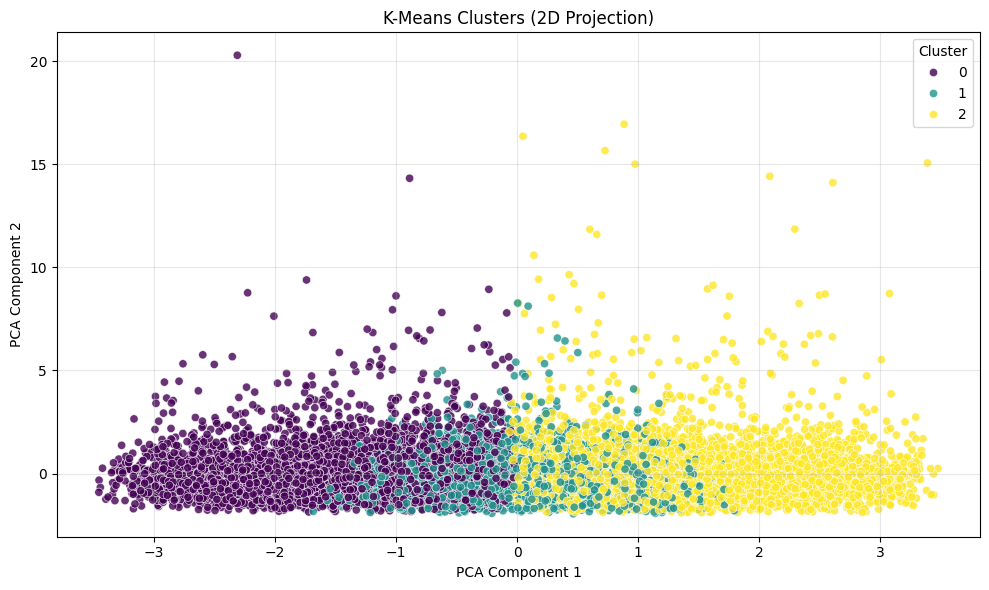

In [25]:
from sklearn.decomposition import PCA

# Reduce data to 2 dimensions using PCA for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_scaled[numerical_features])
reduced_df = pd.DataFrame(reduced_data, columns=["PCA1", "PCA2"])
reduced_df["cluster"] = df_scaled["cluster"]

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PCA1",
    y="PCA2",
    hue="cluster",
    palette="viridis",
    data=reduced_df,
    legend="full",
    alpha=0.8,
)
plt.title("K-Means Clusters (2D Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### How to Read the Clustering Chart

The **clustering chart** visualizes how the data points are grouped into clusters using **Principal Component Analysis (PCA)** to project the high-dimensional data into two dimensions.

**Key Elements of the Chart**:
1. **Axes (PCA1 and PCA2)**:
   - Represent the first two principal components of the data, capturing the most significant variance.
   - These are not original features but combinations of them.

2. **Colored Points**:
   - Each color represents a distinct cluster.
   - Data points within the same cluster are expected to group together.

3. **Cluster Separation**:
   - Well-separated clusters indicate clear distinctions between groups.
   - Overlapping clusters suggest the need to adjust `k` (the number of clusters) or preprocess the data further.

**How to Analyze the Chart**:
- **Compact Clusters**: Indicate well-defined groups with minimal variance.
- **Outliers**: Points far from their cluster center or isolated from other points in the same color may indicate anomalies.
- **Cluster Overlap**: Suggests the chosen `k` might be too large or the data lacks clear separations.

### Analyzing Cluster Characteristics

After visualizing the clusters, the next step is to understand their characteristics. This involves examining the operational metrics within each cluster to identify patterns or unusual behaviors. By analyzing these metrics, we can determine how the clusters differ and detect potential anomalies.

In [26]:
# Analyze cluster characteristics
cluster_summary = df.groupby("cluster")[numerical_features].mean()

# Display the summary table
print("Cluster Summary (Mean Values):")
cluster_summary

Cluster Summary (Mean Values):


,cpu_allocation_efficiency,memory_allocation_efficiency,disk_io,network_latency,node_temperature,node_cpu_usage,node_memory_usage,resource_efficiency,io_latency_ratio
cluster,,,,,,,,,
0,0.377786,0.221416,513.465184,99.311392,59.335199,49.537036,48.862203,0.299601,13.481748
1,0.273834,0.741991,459.234034,104.053962,60.006849,47.481264,50.234404,0.507912,9.124285
2,0.786732,0.604193,515.049929,97.236993,60.890254,50.627970,51.399056,0.695462,15.390191


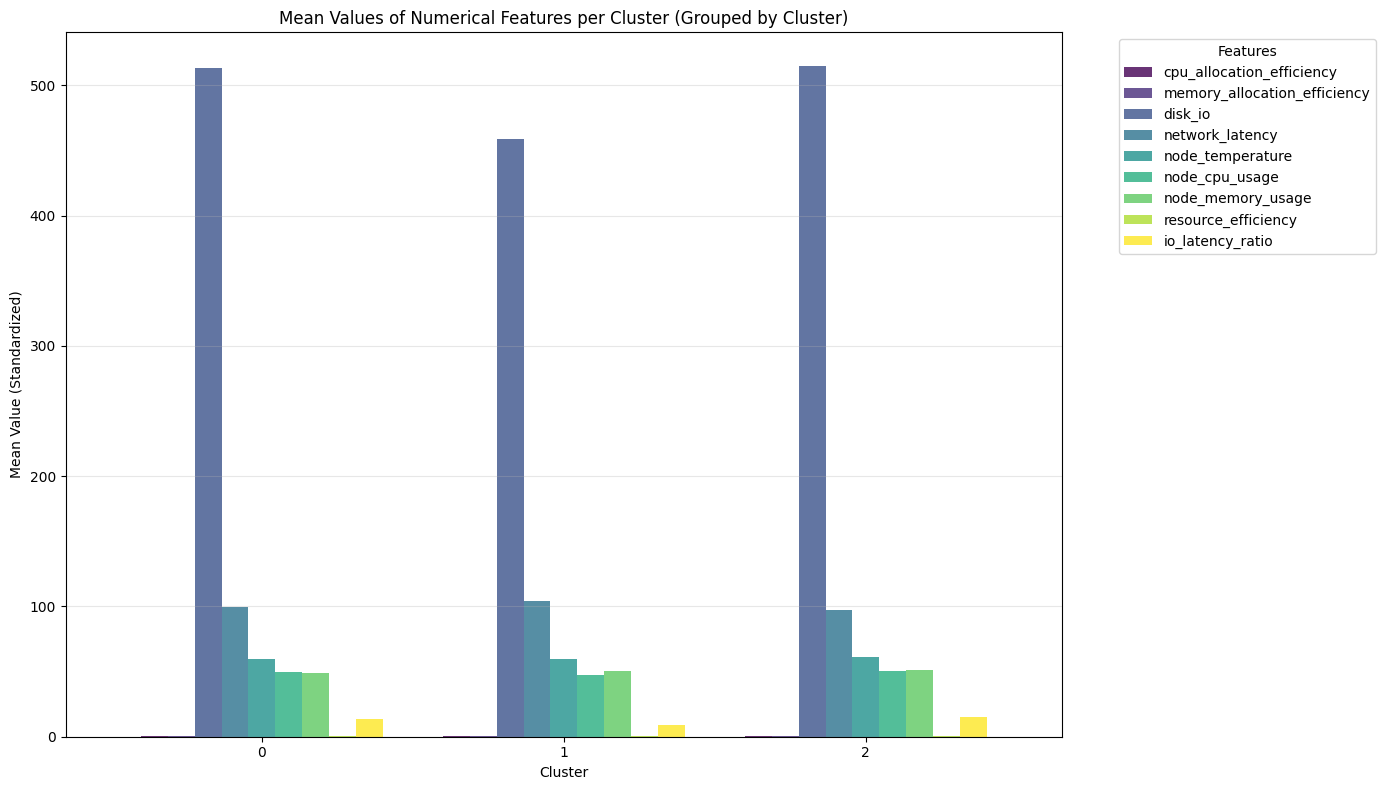

In [27]:
# Visualize cluster characteristics grouped by clusters
cluster_summary.plot(
    kind="bar",
    figsize=(14, 8),
    colormap="viridis",
    alpha=0.8,
    width=0.8,
)
plt.title("Mean Values of Numerical Features per Cluster (Grouped by Cluster)")
plt.ylabel("Mean Value (Standardized)")
plt.xlabel("Cluster")
plt.xticks(rotation=0)  # Keep cluster names horizontal
plt.legend(title="Features", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Identifying Anomalies

Anomalies are data points that deviate significantly from the typical behavior of their cluster. To identify anomalies, we calculate the **distance** of each data point from its assigned cluster center.

### Steps for Anomaly Detection:
1. Calculate the distance of each data point from its cluster center.
2. Set an **anomaly threshold** based on the distribution of distances (e.g., the 95th percentile).
3. Flag data points that exceed the threshold as anomalies.

By analyzing these anomalies, we can detect unusual Kubernetes operational behaviors that may indicate resource inefficiencies, performance degradation, or misconfigurations.

In [28]:
# Calculate the distance of each point from its cluster center
cluster_centers = kmeans.cluster_centers_
distances = np.linalg.norm(
    df_scaled[numerical_features].values - cluster_centers[df_scaled["cluster"]], axis=1
)

# Add the distances to the DataFrame
df["distance_from_center"] = distances

# Define an anomaly threshold (e.g., 95th percentile of distances)
anomaly_threshold = np.percentile(distances, 95)

# Flag anomalies
df["is_anomaly"] = df["distance_from_center"] > anomaly_threshold

# Display the count of anomalies per cluster
print("Anomalies Detected by Cluster:")
print(df.groupby("cluster")["is_anomaly"].sum())

Anomalies Detected by Cluster:
cluster
0    295
1    101
2    354
Name: is_anomaly, dtype: int64


### Visualizing Anomalies

To gain deeper insights, we’ll visualize the anomalies on the PCA scatter plot. This allows us to see how the anomalies deviate from their respective clusters.

#### Key Features of the Visualization:
1. **Cluster Assignments**: Each data point is colored based on its cluster.
2. **Anomalies**: Anomalous points are highlighted in red, indicating their deviation from normal cluster behavior.

This visualization helps pinpoint specific areas in the data where Kubernetes operations may require attention.

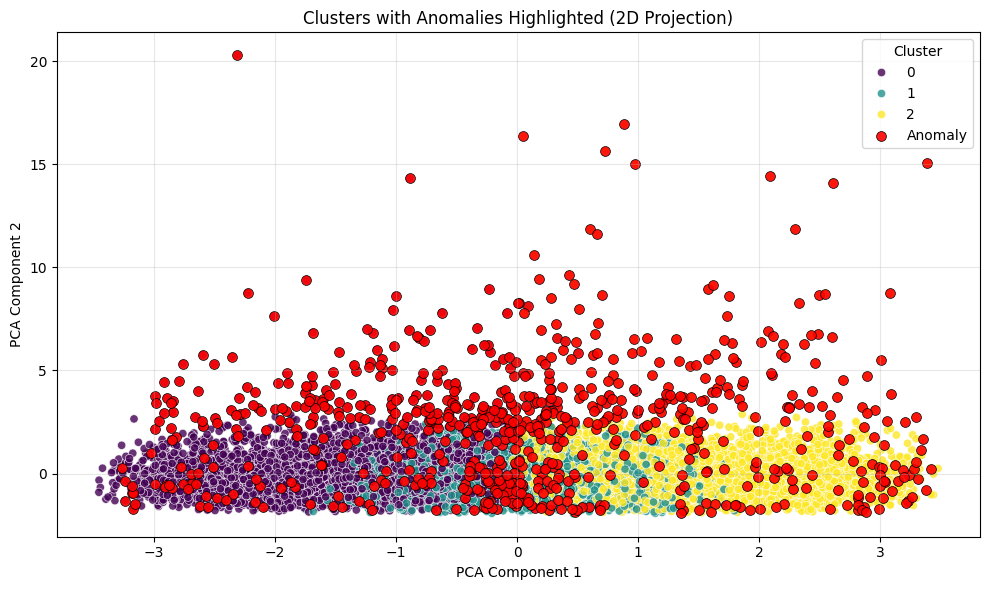

In [29]:
# Add anomaly flag to the reduced PCA DataFrame
reduced_df["is_anomaly"] = df["is_anomaly"]

# Plot anomalies on the PCA scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PCA1",
    y="PCA2",
    hue="cluster",
    palette="viridis",
    data=reduced_df,
    legend="full",
    alpha=0.8,
)
sns.scatterplot(
    x=reduced_df.loc[reduced_df["is_anomaly"], "PCA1"],
    y=reduced_df.loc[reduced_df["is_anomaly"], "PCA2"],
    color="red",
    label="Anomaly",
    s=50,
    alpha=0.9,
    edgecolor="k",
)
plt.title("Clusters with Anomalies Highlighted (2D Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Refining Clusters by Removing Anomalies

Anomalies can distort cluster centroids, reducing the effectiveness of clustering for normal data points. To improve the quality of clustering, we remove anomalies and re-run the **K-Means algorithm** on the cleaned dataset.

### Why Remove Anomalies?
1. **Improved Cluster Definition**: Excluding anomalies results in clusters that better represent natural patterns.
2. **Cleaner Insights**: Focuses the analysis on typical operational behaviors without interference from noisy data.
3. **Iterative Anomaly Detection**: After refining clusters, additional rounds of anomaly detection can identify subtler deviations.

### Steps for Refinement:
1. Filter out data points flagged as anomalies.
2. Re-run the K-Means algorithm on the cleaned dataset.
3. Recalculate the silhouette score to evaluate the quality of the refined clusters.
4. Visualize the updated clusters to confirm improvements.

This iterative approach ensures that our clusters provide actionable insights into the normal and anomalous behaviors of Kubernetes operations.

Silhouette Score after removing anomalies: 0.15


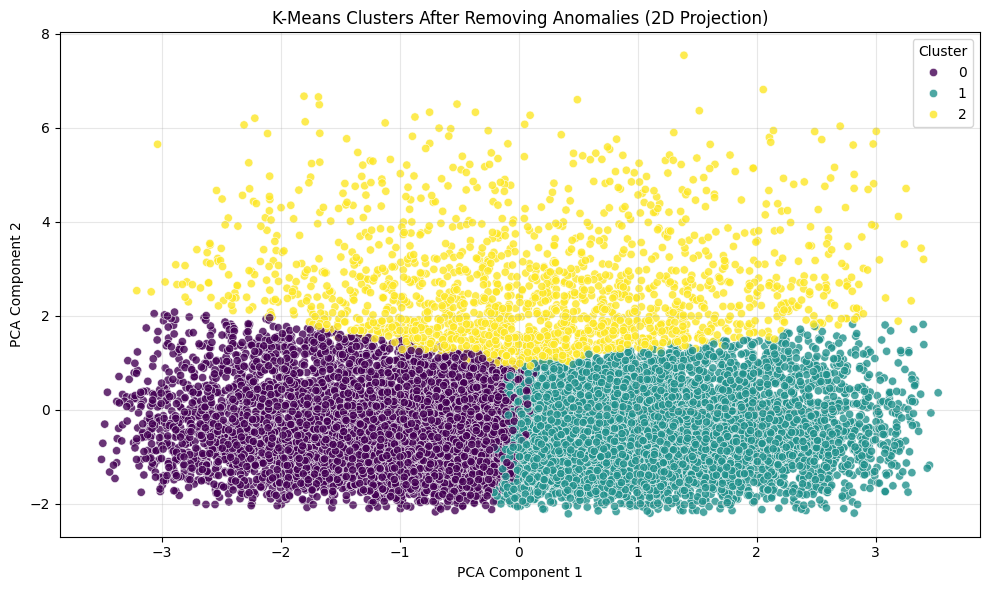

In [30]:
# Remove anomalies from the dataset
cleaned_df = df[df["is_anomaly"] == False]

# Scale the numerical features of the cleaned dataset
cleaned_scaled = scaler.fit_transform(cleaned_df[numerical_features])

# Re-run K-Means on the cleaned data
kmeans_cleaned = KMeans(n_clusters=num_clusters, random_state=42)
cleaned_clusters = kmeans_cleaned.fit_predict(cleaned_scaled)

# Add the new cluster labels to the cleaned dataset using .loc
cleaned_df.loc[:, "cluster"] = cleaned_clusters

# Calculate the new Silhouette Score
silhouette_cleaned = silhouette_score(cleaned_scaled, cleaned_clusters)
print(f"Silhouette Score after removing anomalies: {silhouette_cleaned:.2f}")

# Visualize the refined clusters using PCA
reduced_cleaned_data = pca.fit_transform(cleaned_scaled)
reduced_cleaned_df = pd.DataFrame(reduced_cleaned_data, columns=["PCA1", "PCA2"])
reduced_cleaned_df["cluster"] = cleaned_clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PCA1",
    y="PCA2",
    hue="cluster",
    palette="viridis",
    data=reduced_cleaned_df,
    legend="full",
    alpha=0.8,
)
plt.title("K-Means Clusters After Removing Anomalies (2D Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Insights from Refined Clusters

After removing anomalies and re-running the K-Means algorithm, the refined clusters provide clearer insights into the behavior of Kubernetes operational metrics.

### Key Observations:
1. **Cluster-Specific Patterns**:
   - Each cluster represents a distinct operational state (e.g., balanced resource usage, high load, or inefficiency).
   - Metrics like `cpu_allocation_efficiency` and `network_latency` often differentiate clusters.

2. **Operational Behaviors**:
   - **Cluster 0**: May indicate normal operations with balanced resource usage.
   - **Cluster 1**: Could represent nodes or pods under high load or resource constraints.
   - **Cluster 2**: Might signal inefficiencies, bottlenecks, or risky operational states.

3. **Actionable Insights**:
   - Clusters highlight areas for optimization, such as reallocating resources, reconfiguring pods, or investigating potential issues.
   - Identifying high-risk clusters enables proactive maintenance and issue prevention.

4. **Cross-Feature Relationships**:
   - Comparing metrics within and across clusters helps uncover correlations (e.g., high `disk_io` and `network_latency` signaling a combined issue).

By analyzing refined clusters, you can make data-driven decisions to improve Kubernetes performance and reliability.

In [31]:
# Analyze the refined clusters to derive insights
refined_cluster_summary = cleaned_df.groupby("cluster")[numerical_features].mean()

# Identify the characteristics of each cluster
print("Refined Cluster Characteristics (Mean Values):")
refined_cluster_summary

Refined Cluster Characteristics (Mean Values):


,cpu_allocation_efficiency,memory_allocation_efficiency,disk_io,network_latency,node_temperature,node_cpu_usage,node_memory_usage,resource_efficiency,io_latency_ratio
cluster,,,,,,,,,
0,0.336097,0.317125,479.094385,114.372645,59.464557,49.755792,48.974585,0.326611,5.063373
1,0.648625,0.686385,456.649554,112.730996,60.416472,49.031335,51.490753,0.667505,4.887568
2,0.514590,0.497165,676.207226,26.140458,60.817734,50.093158,50.322620,0.505877,31.339986


In [32]:
# Calculate the distribution of anomalies
anomalies_by_cluster = df.groupby("cluster")["is_anomaly"].sum()
total_anomalies = anomalies_by_cluster.sum()

print("\nAnomalies Distribution Across Clusters:")
print(anomalies_by_cluster)
print(f"\nTotal Anomalies Detected: {total_anomalies}")

# Identify key differentiating metrics
std_dev = cleaned_df[numerical_features].std()
cluster_ranges = refined_cluster_summary / std_dev

print("\nNormalized Metric Ranges per Cluster (Relative to Standard Deviation):")
cluster_ranges


Anomalies Distribution Across Clusters:
cluster
0    295
1    101
2    354
Name: is_anomaly, dtype: int64

Total Anomalies Detected: 750

Normalized Metric Ranges per Cluster (Relative to Standard Deviation):


,cpu_allocation_efficiency,memory_allocation_efficiency,disk_io,network_latency,node_temperature,node_cpu_usage,node_memory_usage,resource_efficiency,io_latency_ratio
cluster,,,,,,,,,
0,1.173231,1.103016,1.687069,2.046329,2.606336,1.750917,1.711630,1.602858,0.455203
1,2.264191,2.387365,1.608033,2.016957,2.648059,1.725423,1.799568,3.275811,0.439398
2,1.796308,1.729223,2.381177,0.467699,2.665646,1.762789,1.758743,2.482616,2.817500


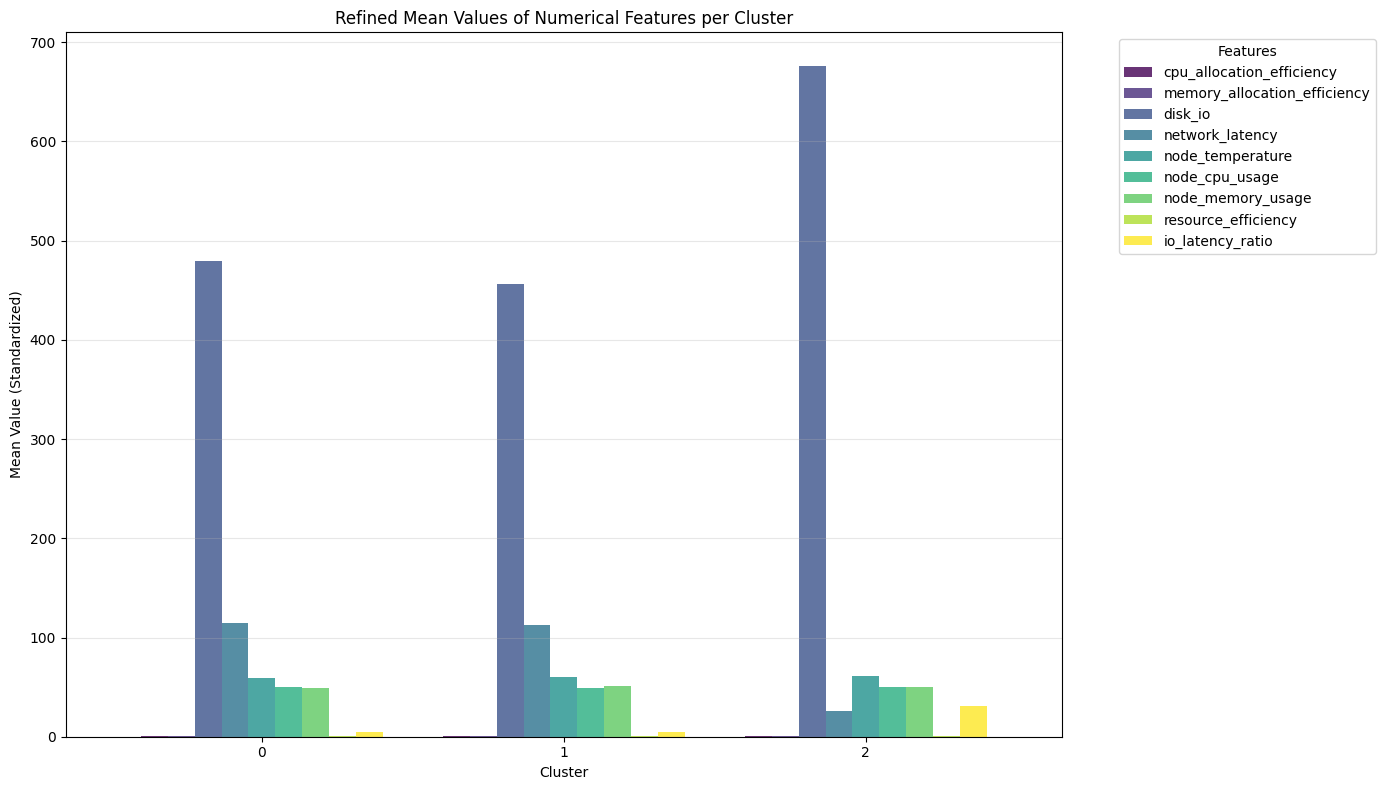

In [33]:
# Visualize cluster-specific metrics grouped by clusters
refined_cluster_summary.plot(
    kind="bar",
    figsize=(14, 8),
    colormap="viridis",
    alpha=0.8,
    width=0.8,
)
plt.title("Refined Mean Values of Numerical Features per Cluster")
plt.ylabel("Mean Value (Standardized)")
plt.xlabel("Cluster")
plt.xticks(rotation=0)  # Keep cluster names horizontal
plt.legend(title="Features", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Conclusion

In this notebook, we explored how **unsupervised learning** can be applied to Kubernetes operational metrics to uncover patterns and detect anomalies.

### Key Takeaways:
1. **Clustering for Anomaly Detection**:
   - Clustering helps group data points with similar behaviors, making it easier to identify outliers or anomalies.
   - Anomalies often signal potential operational risks, such as resource inefficiencies or performance degradation.

2. **Silhouette Score**:
   - Evaluating cluster quality with the silhouette score ensures meaningful and well-separated clusters.

3. **Refinement Through Anomaly Removal**:
   - Removing anomalies improves cluster definitions, enabling more accurate analysis of typical operational states.

4. **Visualization and Insights**:
   - PCA-based visualizations helped identify anomalies and interpret cluster characteristics.

### Practical Applications:
- **Proactive Monitoring**: Use clustering to detect anomalies in Kubernetes environments, such as high resource usage or unusual behavior.
- **Iterative Refinement**: Continuously refine clusters and anomaly thresholds to improve detection accuracy.
- **Operational Insights**: Leverage cluster characteristics to optimize resource allocation, investigate bottlenecks, and improve uptime.

### What’s Next?

In the next notebook, we’ll:
1. Explore **advanced anomaly detection techniques** like Isolation Forests, One-Class SVMs, and Autoencoders.
2. Compare these methods with clustering-based anomaly detection.
3. Understand the trade-offs and best use cases for each approach.

This will further enhance your ability to detect and mitigate risks in Kubernetes operations. See you in the next notebook!